In [1]:
import ROOT

Module libc not found.


Welcome to JupyROOT 6.24/07


In [2]:
ROOT.gSystem.Load('./RooMultiVarGaussian2e_cxx.so')

0


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [3]:
import matplotlib.pyplot as plt
import numpy as np

from os.path import exists

import read_config_utils as cu

In [4]:
import sys
import time

import gc

In [5]:
#input_dir = 'output-files-bootstrap-test6b-6d'

#input_dir = 'bootstrap-simple-pdf-toy-study6b-2d-v1b'

#input_dir = 'output-files-bootstrap-test6b-2d-2a-100k'


#input_dir = 'bootstrap-toy-study6b-2d-4c'

#input_dir = 'bootstrap-simple-pdf-toy-study6b-2d-4c'



#input_dir = 'freshtoys-toy-study6b-2d-4c'

#input_dir = 'freshtoys-simple-pdf-toy-study6b-2d-4c'



#input_dir = 'freshtoys-toy-study6b-2d-4c-save-model'

#input_dir = 'freshtoys-toy-study6b-2d-4c-save-model/freshmc-02'




#input_dir = 'bootstrap-toy-study6b-1d-1a'
#input_dir = 'bootstrap-toy-study6b-1d-1a-badres'
#input_dir = 'bootstrap-toy-study6b-1d-1a-goodres'
#input_dir = 'bootstrap-toy-study6b-1d-1a-verygoodres'
#input_dir = 'bootstrap-toy-study6b-1d-1a-perfect'#



#input_dir = 'fit-pdf-toy-study-2d-1a'

#input_dir = 'fit-pdf-toy-study-1d-1a'

#input_dir = 'hist-pdf-toy-study-1d-1a'

#input_dir = 'hist-pdf-toy-study-1d-1a-nominal-resolution-5k-toys'

#input_dir = 'hist-pdf-toy-study-1d-1a-badres'

#input_dir = 'hist-pdf-toy-study-1d-1b'

#input_dir = 'bootstrap-toy-study8a-1d-1d'

#input_dir = 'bootstrap-toy-study8a-1d-1d-gpu0'


input_dir = 'hist-pdf-toy-study-1d-2a'

#input_dir = 'bootstrap-toy-study8a-1d-2a'

#---


points_file = 'train-and-true-samples.npy'





In [6]:
config_file = '%s/config.txt' % (input_dir)

if not exists(config_file) :
    
    print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
    sys.exit()
    

In [7]:
ndim = int(cu.get_par( config_file, "ndim"))
print("\n\n Number of feature dimensions: %d\n\n" % ndim)



 Number of feature dimensions: 1




In [8]:
with open( '%s/config-pars.npy' % input_dir, 'rb') as f :
    train_mu = np.load(f, allow_pickle=True )
    train_rho = np.load(f, allow_pickle=True)
    train_sig = np.load(f, allow_pickle=True)    
    true_mu = np.load(f, allow_pickle=True )
    true_rho = np.load(f, allow_pickle=True)
    true_sig = np.load(f, allow_pickle=True)  
    resolution = np.load(f, allow_pickle=True)

In [9]:
with open('%s/%s' % (input_dir, points_file),'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)


In [10]:
n_samples = 0

for fi in range(1000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d bootstrap samples.\n\n" % n_samples )



 Found 402 bootstrap samples.




## Read in the main OmniFold ouput for the fake data and fit it before doing the bootstraps

In [11]:
fname = '%s/omnifold-output-weights.npy' % (input_dir)
#fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, 0)  

print('\n\n Reading in %s for weights in test fit.\n\n' % fname)
with open(fname,'rb') as f :
    sample_weights = np.load(f)



 Reading in hist-pdf-toy-study-1d-2a/omnifold-output-weights.npy for weights in test fit.




In [12]:

nmcevts = len(train_pts)

print( "train_pts shape:  %s" % str(train_pts.shape))
print( "weights:  %s" % str(sample_weights.shape))

print( "number of MC events: %d" % nmcevts)

train_pts shape:  (1000000, 1)
weights:  (1000000,)
number of MC events: 1000000


In [13]:


true_cov  = np.zeros( shape=(ndim,ndim) )

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d : diagonal  %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
   

   0,  0 : diagonal    0.8100


## Read in the simple calculation results to set the parameter limits

In [14]:
with open( '%s/simple-calc-results.npy' % input_dir, 'rb') as f :
    sc_ave_mean_val = np.load(f, allow_pickle=True )
    sc_ave_mean_rms = np.load(f, allow_pickle=True)
    sc_ave_cov_val  = np.load(f, allow_pickle=True)    
    sc_ave_cov_rms  = np.load(f, allow_pickle=True )



In [15]:
sc_ave_cov_val

array([[0.83348603]])

In [16]:
print('\n\n')
print('  Simple direct calculation results from the bootstrap samples.\n')

for fi in range(ndim) :
    print('  feature %d  mean:   %8.4f  (true %8.4f) RMS  %8.4f'
         % (fi, sc_ave_mean_val[fi], true_mu[fi], sc_ave_mean_rms[fi]) )
    
print('\n')

for i in range(ndim) :
    for j in range(i,ndim) :
        print('   %d, %d  cov:   %8.4f  (true %8.4f) RMS  %8.4f'
              % ( i, j, sc_ave_cov_val[i][j], true_cov[i,j], sc_ave_cov_rms[i][j]) )

print('\n\n')




  Simple direct calculation results from the bootstrap samples.

  feature 0  mean:     0.1991  (true   0.2000) RMS    0.0037


   0, 0  cov:     0.8335  (true   0.8100) RMS    0.0052





In [17]:
width_factor_mean = 10
width_factor_cov = 10

###  Do it this way to keep all the RooRealVars in memory in separate objects (different elements in the dictionary).

In [18]:
covdict = {}


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        startval = sc_ave_cov_val[i][j]
        minval = sc_ave_cov_val[i][j] - width_factor_cov * sc_ave_cov_rms[i][j]
        maxval = sc_ave_cov_val[i][j] + width_factor_cov * sc_ave_cov_rms[i][j]   
        print(' parameter %s  min %8.4f, max %8.4f' % (vname, minval, maxval))
        if ( i == j ) :
            ######covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), true_cov[i][j], 0.02, 2.0 )           
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        else :
            ######covdict[vname] =   ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), true_cov[i][j], -1.1, 1.1 ) 
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        covdict[vname].Print()
        


 parameter cov00  min   0.7810, max   0.8859
RooRealVar::cov00 = 0.833486  L(0.781025 - 0.885947) 


In [19]:
covRAL = ROOT.RooArgList()


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        covRAL.add( covdict[vname] )


In [20]:
ralind = 0
for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        print( "  %d, %d :  %2d :  %s  %8.3f" % (i,j, ralind, covRAL.at(ralind).GetName(), covRAL.at(ralind).getVal() )) 
        ralind = ralind + 1

  0, 0 :   0 :  cov00     0.833


### The Dict keeps the variables defined in memory

In [21]:
xDict = {}
muDict = {}

xVec = ROOT.RooArgList()
muVec = ROOT.RooArgList()


for i in range(ndim) :
    vname = "x%d" % i
    xDict[vname] = ROOT.RooRealVar( vname, vname, 0., -10., 10. )
    xVec.add( xDict[vname] )
    vname = "mu_x%d" % i
    startval = sc_ave_mean_val[i]
    minval = sc_ave_mean_val[i] - width_factor_mean * sc_ave_mean_rms[i]
    maxval = sc_ave_mean_val[i] + width_factor_mean * sc_ave_mean_rms[i]
    print('  feature %d  mean :  min %8.4f, max %8.4f' % (i, minval, maxval))
    ##########muDict[vname] =  ROOT.RooRealVar( vname, vname, true_mu[i], -2., 2. )
    muDict[vname] =  ROOT.RooRealVar( vname, vname, startval, minval, maxval )
    muDict[vname].Print()
    muVec.add( muDict[vname] )
    
    
weight = ROOT.RooRealVar("weight","weight", 0., 100. )

  feature 0  mean :  min   0.1621, max   0.2361
RooRealVar::mu_x0 = 0.199136  L(0.162143 - 0.23613) 


In [22]:
rmvg = ROOT.RooMultiVarGaussian2e("rmvg","rmvg", xVec, muVec, covRAL )

  Setting _prevCovVals[0] to 0.833486
 i,j = 0,0

1x1 matrix is as follows

     |      0    |
------------------
   0 |     0.8335 


1x1 matrix is as follows

     |      0    |
------------------
   0 |          0 



 cov inverse.

1x1 matrix is as follows

     |      0    |
------------------
   0 |        1.2 



 Check of inverse

1x1 matrix is as follows

     |      0    |
------------------
   0 |          1 



In [23]:
xVec.Print("V")

  1) RooRealVar:: x0 = 0


In [24]:
data_test = ROOT.RooDataSet( "data_test", "data_test", ROOT.RooArgSet(xVec, weight) , ROOT.RooFit.WeightVar("weight"))
ROOT.SetOwnership( data_test, True )

In [25]:
%%time

for i in range( len(sample_weights) ) :
    if i % (len(sample_weights)/100 ) == 0 : print( " %9d / %9d  (%6.0f)%%" % (i, len(sample_weights), 100*i/len(sample_weights)))
    for j in range( ndim ) :
        xVec[j].setVal( train_pts[i,j] )
    weight.setVal( sample_weights[i])
    data_test.add( ROOT.RooArgSet(xVec, weight), weight.getVal() )

         0 /   1000000  (     0)%
     10000 /   1000000  (     1)%
     20000 /   1000000  (     2)%
     30000 /   1000000  (     3)%
     40000 /   1000000  (     4)%
     50000 /   1000000  (     5)%
     60000 /   1000000  (     6)%
     70000 /   1000000  (     7)%
     80000 /   1000000  (     8)%
     90000 /   1000000  (     9)%
    100000 /   1000000  (    10)%
    110000 /   1000000  (    11)%
    120000 /   1000000  (    12)%
    130000 /   1000000  (    13)%
    140000 /   1000000  (    14)%
    150000 /   1000000  (    15)%
    160000 /   1000000  (    16)%
    170000 /   1000000  (    17)%
    180000 /   1000000  (    18)%
    190000 /   1000000  (    19)%
    200000 /   1000000  (    20)%
    210000 /   1000000  (    21)%
    220000 /   1000000  (    22)%
    230000 /   1000000  (    23)%
    240000 /   1000000  (    24)%
    250000 /   1000000  (    25)%
    260000 /   1000000  (    26)%
    270000 /   1000000  (    27)%
    280000 /   1000000  (    28)%
    290000 /  

In [26]:
data_test

In [27]:
data_test.Print("V")

DataStore data_test (data_test)
  Contains 1000000 entries
  Observables: 
    1)  x0 = 0.632502  L(-10 - 10)  "x0"
  Dataset variable "weight" is interpreted as the event weight


In [28]:
data_test.get(0).Print("V")

  1) RooRealVar:: x0 = -1.89398


In [29]:

for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        if ( i == j ) : continue
        vname = "cov%d%d" % (i,j)
        #########covRAL.find(vname).setConstant()

In [30]:
covRAL.Print("V")

  1) RooRealVar:: cov00 = 0.833486


In [31]:
covRAL.find("cov00").isConstant()

False

In [32]:
%%time

rfr = rmvg.fitTo( data_test, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
ROOT.SetOwnership( rfr, True )


CPU times: user 43.1 ms, sys: 302 ms, total: 345 ms
Wall time: 1.38 s
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
  copy constructor, Setting _prevCovVals[0] to 0.833486
[#1] INFO:Eval -- RooAbsTestStatistic::initMPMode: started 28 remote server process.
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 cov00        8.33486e-01  1.04923e-02    7.81025e-01  8.85947e-01
     2 mu_x0        1.99136e-01  7.39864e-03    1.62143e-01  2.36130e-01
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        1000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MI

In [33]:
covRAL.Print("V")

  1) RooRealVar:: cov00 = 0.834877 +/- 0.00372963


In [34]:
for i in range(ndim) :
    fit_mean = muDict["mu_x%d" % i].getVal()
    fit_mean_err = muDict["mu_x%d" % i].getError()
    print("  %2d :  mu = %8.4f   (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
          (i, fit_mean, true_mu[i], fit_mean_err, (fit_mean-true_mu[i]), (fit_mean-true_mu[i])/fit_mean_err) )

print("\n")

for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        fit_cov = covdict["cov%d%d" % (i,j)].getVal()
        fit_cov_err = covdict["cov%d%d" % (i,j)].getError()
        print(" %2d, %2d :  cov  %8.4f  (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
              (i,j, fit_cov, true_cov[i][j], fit_cov_err, 
               (fit_cov-true_cov[i][j]), (fit_cov-true_cov[i][j])/fit_cov_err)  )

   0 :  mu =   0.2000   (true   0.2000) err   0.0029  diff  -0.0000   diff/err  -0.01


  0,  0 :  cov    0.8349  (true   0.8100) err   0.0037  diff   0.0249   diff/err   6.67


In [35]:

del data_test
del rfr
gc.collect()

0

In [36]:
n_samples = np.min( [n_samples,50] )

In [37]:
fit_results_mean_val = np.zeros( shape=(ndim, n_samples ) )
fit_results_mean_err = np.zeros( shape=(ndim, n_samples ) )
fit_results_cov_val = np.zeros( shape=(ndim, ndim, n_samples ) )
fit_results_cov_err = np.zeros( shape=(ndim, ndim, n_samples ) )

In [38]:
%%time

#### TESTING
###n_samples = 1

for bi in range( n_samples ) :
    
    print("\n\n --- bootstrap sample %3d" % bi, flush=True )
    sys.stdout.flush()
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, bi)    
    print('Reading weights file : %s' % fname )
    
    with open(fname,'rb') as f :
        bootstrap_sample_weights = np.load(f)
        
    data_weighted = ROOT.RooDataSet("data_weighted","data_weighted", ROOT.RooArgSet(xVec,weight), ROOT.RooFit.WeightVar("weight"))
    ROOT.SetOwnership( data_weighted, True )
    
    print('Filling RooDataSet with %d events' % len(bootstrap_sample_weights) )
    for i in range( len(bootstrap_sample_weights) ) :
        for j in range( ndim ) :
            xVec[j].setVal( train_pts[i,j] )
        weight.setVal( bootstrap_sample_weights[i] )
        data_weighted.add( ROOT.RooArgSet(xVec,weight), weight.getVal() )
        
    print("  Running fit...")
    sys.stdout.flush()
        
    rfr = rmvg.fitTo( data_weighted, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
    ROOT.SetOwnership( rfr, True )
    
    for i in range(ndim) :
        fit_mean = muDict["mu_x%d" % i].getVal()
        fit_mean_err = muDict["mu_x%d" % i].getError()
        fit_results_mean_val[i,bi] = fit_mean
        fit_results_mean_err[i,bi] = fit_mean_err
        print("  %2d :  mu = %8.4f   (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
              (i, fit_mean, true_mu[i], fit_mean_err, (fit_mean-true_mu[i]), (fit_mean-true_mu[i])/fit_mean_err) )

    print("\n")

    for i in range(ndim) :
        for j in range(ndim) :
            if ( j < i ) : continue
            fit_cov = covdict["cov%d%d" % (i,j)].getVal()
            fit_cov_err = covdict["cov%d%d" % (i,j)].getError()
            fit_results_cov_val[i,j,bi] = fit_cov
            fit_results_cov_err[i,j,bi] = fit_cov_err
            print(" %2d, %2d :  cov  %8.4f  (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
                  (i,j, fit_cov, true_cov[i][j], fit_cov_err, 
                   (fit_cov-true_cov[i][j]), (fit_cov-true_cov[i][j])/fit_cov_err)  )
    
    print("Cleaning up.")
    del bootstrap_sample_weights
    del data_weighted
    del rfr
    gc.collect()
    #print("Pausing for 3 seconds.")
    #time.sleep(3)        
        
        



 --- bootstrap sample   0
Reading weights file : hist-pdf-toy-study-1d-2a/bootstrap-weights-000.npy
Filling RooDataSet with 1000000 events
  Running fit...
   0 :  mu =   0.1984   (true   0.2000) err   0.0029  diff  -0.0016   diff/err  -0.56


  0,  0 :  cov    0.8310  (true   0.8100) err   0.0037  diff   0.0210   diff/err   5.66
Cleaning up.


 --- bootstrap sample   1
Reading weights file : hist-pdf-toy-study-1d-2a/bootstrap-weights-001.npy
Filling RooDataSet with 1000000 events
  Running fit...
   0 :  mu =   0.2040   (true   0.2000) err   0.0029  diff   0.0040   diff/err   1.37


  0,  0 :  cov    0.8325  (true   0.8100) err   0.0037  diff   0.0225   diff/err   6.05
Cleaning up.


 --- bootstrap sample   2
Reading weights file : hist-pdf-toy-study-1d-2a/bootstrap-weights-002.npy
Filling RooDataSet with 1000000 events
  Running fit...
   0 :  mu =   0.1925   (true   0.2000) err   0.0029  diff  -0.0075   diff/err  -2.61


  0,  0 :  cov    0.8339  (true   0.8100) err   0.0037  diff



 --- bootstrap sample  24
Reading weights file : hist-pdf-toy-study-1d-2a/bootstrap-weights-024.npy
Filling RooDataSet with 1000000 events
  Running fit...
   0 :  mu =   0.1985   (true   0.2000) err   0.0029  diff  -0.0015   diff/err  -0.53


  0,  0 :  cov    0.8270  (true   0.8100) err   0.0037  diff   0.0170   diff/err   4.59
Cleaning up.


 --- bootstrap sample  25
Reading weights file : hist-pdf-toy-study-1d-2a/bootstrap-weights-025.npy
Filling RooDataSet with 1000000 events
  Running fit...
   0 :  mu =   0.1991   (true   0.2000) err   0.0029  diff  -0.0009   diff/err  -0.31


  0,  0 :  cov    0.8347  (true   0.8100) err   0.0037  diff   0.0247   diff/err   6.64
Cleaning up.


 --- bootstrap sample  26
Reading weights file : hist-pdf-toy-study-1d-2a/bootstrap-weights-026.npy
Filling RooDataSet with 1000000 events
  Running fit...
   0 :  mu =   0.1963   (true   0.2000) err   0.0029  diff  -0.0037   diff/err  -1.28


  0,  0 :  cov    0.8339  (true   0.8100) err   0.0037  diff

 --- bootstrap sample  48
Reading weights file : hist-pdf-toy-study-1d-2a/bootstrap-weights-048.npy
Filling RooDataSet with 1000000 events
  Running fit...
   0 :  mu =   0.1984   (true   0.2000) err   0.0029  diff  -0.0016   diff/err  -0.55


  0,  0 :  cov    0.8365  (true   0.8100) err   0.0037  diff   0.0265   diff/err   7.09
Cleaning up.


 --- bootstrap sample  49
Reading weights file : hist-pdf-toy-study-1d-2a/bootstrap-weights-049.npy
Filling RooDataSet with 1000000 events
  Running fit...
   0 :  mu =   0.1919   (true   0.2000) err   0.0029  diff  -0.0081   diff/err  -2.79


  0,  0 :  cov    0.8377  (true   0.8100) err   0.0037  diff   0.0277   diff/err   7.40
Cleaning up.
CPU times: user 3min 42s, sys: 15.9 s, total: 3min 58s
Wall time: 4min 48s
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
  copy constructor, Setting _prevCovVals[0] to 0.834877
[#1] INFO:Eval -- RooAbsTestStatistic::initMPMode: started 28 remote server process.
 ********

In [39]:
with open( '%s/fit-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, fit_results_mean_val )
    np.save( f, fit_results_mean_err )
    np.save( f, fit_results_cov_val )
    np.save( f, fit_results_cov_err )

<function matplotlib.pyplot.show(close=None, block=None)>

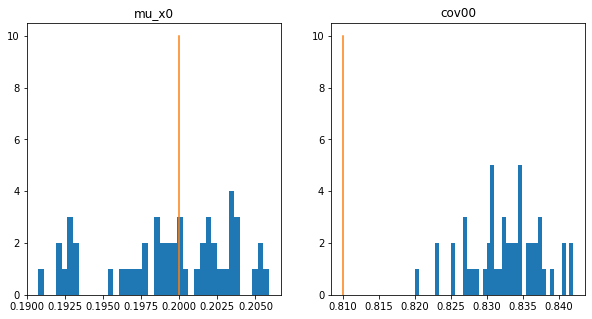

In [40]:
fig,ax = plt.subplots( ndim, 2, figsize=(10,5*ndim))

hbins=40

for i in range(ndim) :
    
    if ndim > 1 :
        thisax = ax[i][0]
    else :
        thisax = ax[0]
    
    thisax.hist( fit_results_mean_val[i,:], bins=hbins)
    thisax.plot( [true_mu[i], true_mu[i]], [0,10])
    thisax.set_title( 'mu_x%d' % i )
    
    if ndim > 1 :
        thisax = ax[i][1]
    else :
        thisax = ax[1]    
    
    thisax.hist( fit_results_cov_val[i,i,:], bins=hbins)
    thisax.plot( [true_sig[i]*true_sig[i], true_sig[i]*true_sig[i]], [0,10])
    thisax.set_title( 'cov%d%d' % (i,i) )

plt.show